In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis-2/THESIS-1
import sys
sys.path.append("/content/drive/MyDrive/Thesis-2/THESIS-1")

Mounted at /content/drive
/content/drive/MyDrive/Thesis-2/THESIS-1


# Convolutional Autoencoder (ConvAE) Training

Trains a convolutional autoencoder exclusively on **normal network traffic sequences** to learn compressed representations of benign patterns. The model learns to reconstruct normal data with low error, making it sensitive to anomalies which produce higher reconstruction errors. This reconstruction error becomes the intrinsic reward signal for the PPO agent.

The training pipeline includes validation-based early stopping, learning rate scheduling, and continuous evaluation against a sample of known anomalies to monitor discrimination capability. The model outputs normalized error statistics (mean, std) used by the PPO environment to scale intrinsic rewards consistently.

## Training Configuration

| Parameter | Value |
|-----------|-------|
| Input shape | (32, features) - sequential windows |
| Latent dimension | 128-dim compressed representation |
| Optimizer | Adam (lr=1e-3, weight_decay=1e-5) |
| Loss function | MSE (Mean Squared Error) |
| Batch size | 128 |
| Max epochs | 100 |
| Early stopping patience | 5 epochs |
| LR scheduler | ReduceLROnPlateau (patience=10, factor=0.5) |

## Evaluation Metrics (During Training)

For each epoch, the model tracks:
- **Train Loss**: Average MSE on normal training data
- **Val Loss**: Average MSE on held-out normal validation data
- **Anomaly Error**: Mean reconstruction error on 1,000 labeled anomalies
- **Ratio**: (Anomaly Error / Normal Error) - measures separation capability
- **AUROC**: Area under ROC curve comparing normal vs. anomaly reconstruction errors

Higher ratio and AUROC values indicate better anomaly discrimination.

## Output Files

| File | Purpose |
|------|---------|
| `convAE_best.pth` | Best model weights (lowest validation loss) |
| `convAE_final.pth` | Final model weights after training completes |
| `convAE_stats.npz` | Normalization statistics (`mean_err`, `std_err`) for PPO environment |

## Workflow
```
Normal sequences (X_ae.npy)
         ↓
[80/20 Train/Val Split]
         ↓
[ConvAE Training Loop]
  • Forward pass: encode → decode
  • MSE loss on reconstruction
  • Backprop + optimizer step
         ↓
[Validation + Early Stopping]
  • Track val loss
  • Save best model
  • Compute error on anomalies
         ↓
[Compute Stats on Full Dataset]
  • Mean reconstruction error
  • Std reconstruction error
         ↓
Save: convAE_best.pth + convAE_stats.npz
```

## Key Features

- **Anomaly-Free Training**: Only normal sequences ensure the model learns "normal" patterns exclusively
- **Early Stopping**: Prevents overfitting by monitoring validation loss
- **Anomaly Evaluation**: Tracks separation between normal and anomalous reconstruction errors during training
- **Normalization Stats**: Computes mean/std for consistent error scaling in PPO intrinsic rewards

**Status:** Complete ConvAE training pipeline ready for PPO integration

🔹 Loading preprocessed AE dataset...
Loaded ConvAE training set: (166987, 32, 47) (pure normals)
Loaded 1000 labeled anomaly samples for AE evaluation.
Starting ConvAE training...

Epoch 005/100 | Train: 0.206158 | Val: 0.190547 | AnomErr: 0.374840 | Ratio: 1.97× | AUROC: 0.8983
Epoch 010/100 | Train: 0.152002 | Val: 0.146779 | AnomErr: 0.348575 | Ratio: 2.37× | AUROC: 0.9171
Epoch 015/100 | Train: 0.128677 | Val: 0.127616 | AnomErr: 0.341335 | Ratio: 2.67× | AUROC: 0.9302
Epoch 020/100 | Train: 0.120473 | Val: 0.129022 | AnomErr: 0.342626 | Ratio: 2.66× | AUROC: 0.9365
Epoch 025/100 | Train: 0.109219 | Val: 0.112867 | AnomErr: 0.341996 | Ratio: 3.03× | AUROC: 0.9431
Epoch 030/100 | Train: 0.098385 | Val: 0.098478 | AnomErr: 0.340587 | Ratio: 3.46× | AUROC: 0.9481
Epoch 035/100 | Train: 0.096224 | Val: 0.094206 | AnomErr: 0.339480 | Ratio: 3.60× | AUROC: 0.9515
Epoch 040/100 | Train: 0.092929 | Val: 0.101890 | AnomErr: 0.342355 | Ratio: 3.36× | AUROC: 0.9528
⏹️ Early stopping at epoch 

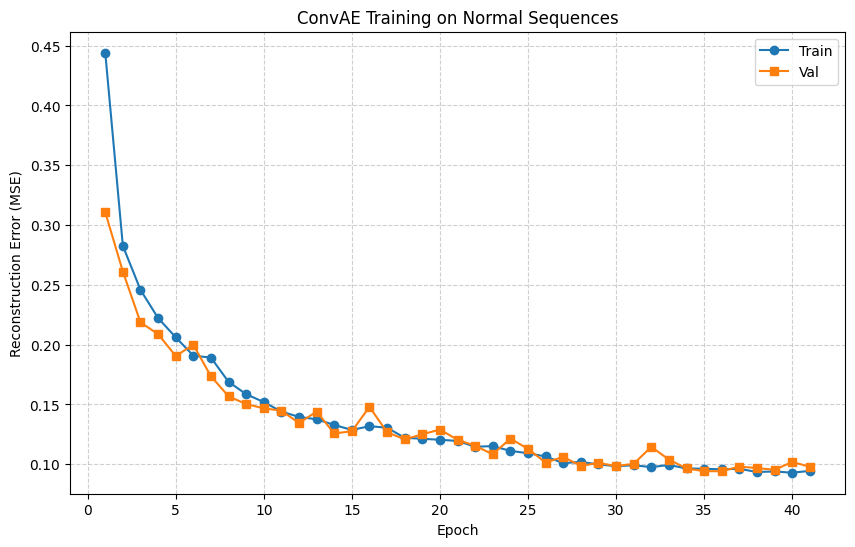

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from convAE import ConvAE

# ============================================================
# 1. Load Data
# ============================================================
print("🔹 Loading preprocessed AE dataset...")
X_normals = np.load("X_ae.npy").astype(np.float32)
print(f"Loaded ConvAE training set: {X_normals.shape} (pure normals)")

# Load labeled anomalies for evaluation
try:
    X_labeled = np.load("X_labeled.npy").astype(np.float32)
    K = min(1000, len(X_labeled))
    X_labeled_sample = X_labeled[:K]
    print(f"Loaded {K} labeled anomaly samples for AE evaluation.")
except Exception as e:
    print(" No labeled anomalies found for AE evaluation. Skipping anomaly metrics.")
    X_labeled_sample = None

# ============================================================
# 2. Dataset + Loaders
# ============================================================
dataset = TensorDataset(torch.tensor(X_normals))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

# ============================================================
# 3. Model Setup
# ============================================================
seq_len, feat_dim = X_normals.shape[1], X_normals.shape[2]
ae_model = ConvAE(feat_dim=feat_dim, seq_len=seq_len, latent_dim=128)

device = "cuda" if torch.cuda.is_available() else "cpu"
ae_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

# ============================================================
# 4. Training Loop
# ============================================================
epochs = 100
train_losses, val_losses = [], []
best_val_loss = float("inf")
patience, patience_counter = 5, 0

print("Starting ConvAE training...\n")

for epoch in range(epochs):
    ae_model.train()
    total_train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        recon = ae_model(x)
        loss = criterion(recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    ae_model.eval()
    total_val_loss = 0
    val_errs = []
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            recon = ae_model(x)
            val_loss = criterion(recon, x).item()
            total_val_loss += val_loss
            per_sample = F.mse_loss(recon, x, reduction="none").mean(dim=(1, 2))
            val_errs.append(per_sample.cpu().numpy())
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(ae_model.state_dict(), "convAE_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

    # --- Optional: Anomaly Evaluation ---
    if X_labeled_sample is not None:
        with torch.no_grad():
            val_errs = np.concatenate(val_errs)
            mean_val_err = val_errs.mean()

            anom_batch = torch.tensor(X_labeled_sample, dtype=torch.float32).to(device)
            recon_anom = ae_model(anom_batch)
            per_sample_err_anom = F.mse_loss(recon_anom, anom_batch, reduction="none").mean(dim=(1, 2)).cpu().numpy()
            mean_anom_err = per_sample_err_anom.mean()

            ratio = mean_anom_err / mean_val_err if mean_val_err > 0 else float("inf")
            M = min(2000, len(val_errs), len(per_sample_err_anom))
            if M > 0:
                y_true = np.concatenate([np.zeros(M), np.ones(M)])
                scores = np.concatenate([val_errs[:M], per_sample_err_anom[:M]])
                auc = roc_auc_score(y_true, scores)
            else:
                auc = float("nan")

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | "
                  f"Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | "
                  f"AnomErr: {mean_anom_err:.6f} | Ratio: {ratio:.2f}× | AUROC: {auc:.4f}")
    else:
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | "
                  f"Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f}")

# ============================================================
# 5. Post-Training
# ============================================================
print("\n✅ Training complete! Best model saved as convAE_best.pth")

torch.save(ae_model.state_dict(), "convAE_final.pth")

# Compute normalization stats for PPOEnv
with torch.no_grad():
    ae_model.eval()
    val_loader_full = DataLoader(dataset, batch_size=128, shuffle=False)
    all_errs = []
    for batch in val_loader_full:
        x = batch[0].to(device)
        recon = ae_model(x)
        per_sample = F.mse_loss(recon, x, reduction="none").mean(dim=(1, 2))
        all_errs.append(per_sample.cpu().numpy())
    all_errs = np.concatenate(all_errs)
    mean_err, std_err = float(all_errs.mean()), float(all_errs.std())

np.savez("convAE_stats.npz", mean_err=mean_err, std_err=std_err)
print(f"📊 Saved AE stats for PPOEnv: mean={mean_err:.6f}, std={std_err:.6f}")

# ============================================================
# 6. Plot Training Curves
# ============================================================
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val", marker="s")
plt.xlabel("Epoch"); plt.ylabel("Reconstruction Error (MSE)")
plt.title("ConvAE Training on Normal Sequences")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [3]:
# ============================================================
# 7. Compute Quartiles & IQR-based Confidence Threshold
# ============================================================
print("\n🔍 Computing quartiles and IQR threshold on normal reconstruction errors...")

# Use the all_errs from post-training (already computed above)
# If you didn't keep it, re-run the error collection block here if needed
# For now, assuming all_errs is still in memory from cell #5

if 'all_errs' in globals() and len(all_errs) > 0:
    normal_mse = all_errs  # raw MSE values on normals
else:
    print("Warning: all_errs not found. Recomputing...")
    # (optional: paste the error collection loop here if needed)

# Raw MSE quartiles
Q1 = np.percentile(normal_mse, 25)
Q2 = np.percentile(normal_mse, 50)
Q3 = np.percentile(normal_mse, 75)
IQR = Q3 - Q1

# Thresholds
threshold_mild = Q3 + 1.5 * IQR    # standard
threshold_conservative = Q3 + 3.0 * IQR

# Normalized (using the saved mean/std)
normalized_mse = (normal_mse - mean_err) / std_err
Q1_norm = np.percentile(normalized_mse, 25)
Q3_norm = np.percentile(normalized_mse, 75)
IQR_norm = Q3_norm - Q1_norm
threshold_norm_mild = Q3_norm + 1.5 * IQR_norm

# Basic stats: estimated false positive rate on normals
fpr_mild_raw = np.mean(normal_mse > threshold_mild) * 100
fpr_conservative_raw = np.mean(normal_mse > threshold_conservative) * 100

print("\nRaw MSE Quartiles & Thresholds:")
print(f"  Q1 (25th):     {Q1:.6f}")
print(f"  Median (Q2):   {Q2:.6f}")
print(f"  Q3 (75th):     {Q3:.6f}")
print(f"  IQR:           {IQR:.6f}")
print(f"  Threshold (k=1.5): {threshold_mild:.6f}  → Est. FPR: {fpr_mild_raw:.2f}%")
print(f"  Threshold (k=3.0): {threshold_conservative:.6f}  → Est. FPR: {fpr_conservative_raw:.2f}%")

print("\nNormalized MSE Quartiles & Threshold:")
print(f"  Q1_norm:       {Q1_norm:.6f}")
print(f"  Q3_norm:       {Q3_norm:.6f}")
print(f"  IQR_norm:      {IQR_norm:.6f}")
print(f"  Threshold_norm (k=1.5): {threshold_norm_mild:.6f}")

# Optional: Save thresholds for later use
thresholds_dict = {
    'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
    'threshold_k1_5': threshold_mild,
    'threshold_k3_0': threshold_conservative
}
np.savez("convAE_thresholds.npz", **thresholds_dict)
print("Thresholds saved to convAE_thresholds.npz")


🔍 Computing quartiles and IQR threshold on normal reconstruction errors...

Raw MSE Quartiles & Thresholds:
  Q1 (25th):     0.016363
  Median (Q2):   0.026804
  Q3 (75th):     0.045908
  IQR:           0.029545
  Threshold (k=1.5): 0.090226  → Est. FPR: 5.39%
  Threshold (k=3.0): 0.134543  → Est. FPR: 2.34%

Normalized MSE Quartiles & Threshold:
  Q1_norm:       -0.086011
  Q3_norm:       -0.054085
  IQR_norm:      0.031926
  Threshold_norm (k=1.5): -0.006197
Thresholds saved to convAE_thresholds.npz


In [8]:
# After computing normal_mse
normalized_mse = (normal_mse - mean_err) / (std_err + 1e-8)
tanh_err = np.tanh(normalized_mse)
clipped_err = np.maximum(0, tanh_err)  # your err

# Quartiles on final err (clipped tanh)
Q1_err = np.percentile(clipped_err, 25)
Q3_err = np.percentile(clipped_err, 75)
IQR_err = Q3_err - Q1_err
threshold_err_k15 = Q3_err + 1.5 * IQR_err

fpr_err_k15 = np.mean(clipped_err > threshold_err_k15) * 100  # should be low (~0.5–5%)

print("\nFinal Err (tanh-normalized) Quartiles & Threshold:")
print(f"  Q1_err: {Q1_err:.4f}")
print(f"  Q3_err: {Q3_err:.4f}")
print(f"  IQR_err: {IQR_err:.4f}")
print(f"  Threshold_err (k=1.5): {threshold_err_k15:.4f} → Est. FPR: {fpr_err_k15:.2f}%")


Final Err (tanh-normalized) Quartiles & Threshold:
  Q1_err: 0.0000
  Q3_err: 0.0000
  IQR_err: 0.0000
  Threshold_err (k=1.5): 0.0000 → Est. FPR: 4.70%


In [5]:
# After computing all_errs (normal validation errors)
threshold_geometric = np.sqrt(mean_err * 0.55)          # rough anom mean from logs ~0.51-0.64
threshold_conservative = mean_err * 2.5
threshold_balanced = mean_err * 2.2                     # tweakable

print(f"Geometric threshold suggestion : {threshold_geometric:.6f}")
print(f"Conservative (2.5×)             : {threshold_conservative:.6f}")
print(f"Balanced (2.2×)                 : {mean_err * 2.2:.6f}")

# Optional: fraction of normals above threshold (sanity check)
fp_rate_geometric = (all_errs > threshold_geometric).mean()
print(f"False positive rate at geometric threshold: {fp_rate_geometric:.4%}")

Geometric threshold suggestion : 0.229735
Conservative (2.5×)             : 0.239901
Balanced (2.2×)                 : 0.211113
False positive rate at geometric threshold: 1.1833%


In [6]:
def get_threshold(model, val_loader, percentile=99):
    model.eval()
    reconstruction_errors = []
    device = next(model.parameters()).device

    print(f"Running on {device}...")

    with torch.no_grad():
        for batch in val_loader:
            # 1. Extract sequence from batch (handles [data, label] pairs)
            seq = batch[0] if isinstance(batch, (list, tuple)) else batch
            seq = seq.to(device) # Shape: (Batch, Seq_Len, Feat) e.g. (16, 20, 10)

            # 2. FORCE the shape to (Batch, Feat, Seq_Len)
            # This is what Conv1d specifically requires.
            # We move dimension 2 (features) to the middle.
            seq_for_model = seq.permute(0, 2, 1) # Now (16, 10, 20)

            # 3. Pass through model
            output = model(seq_for_model) # Output will be (16, 10, 20)

            # 4. Calculate MSE
            # We compare the output to our rearranged input
            loss = torch.mean((output - seq_for_model) ** 2, dim=(1, 2))
            reconstruction_errors.extend(loss.cpu().numpy())

    # Calculate the threshold
    threshold = np.percentile(reconstruction_errors, percentile)

    print("-" * 30)
    print(f"SUCCESS! Threshold: {threshold:.6f}")
    print("-" * 30)

    return threshold